In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets.cityscapes import setupDatasetsAndLoaders

In [2]:
# CUDA check
CUDA = True
device = "cuda" if (torch.cuda.is_available() and CUDA) else "cpu"
print(torch.cuda.is_available())
print(device)

True
cuda


In [3]:
print(torch.__version__)

1.4.0


### Datasets and Dataloader

image name: ('ulm_000003_000019_leftImg8bit',)
image tensor size: torch.Size([1, 3, 1024, 2048])
annotated output tensor size: torch.Size([1, 1024, 2048])


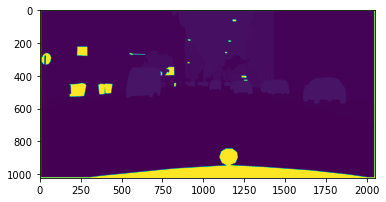

In [4]:
train_set, val_set, test_set, train_loader, val_loader, test_loader = setupDatasetsAndLoaders('./data', batch_size=1)

for sample in train_loader:
    imgSeq, annotatedOutput, imgName = sample

    print(f'image name: {imgName}')
    print(f'image tensor size: {imgSeq[-1].shape}')
    print(f'annotated output tensor size: {annotatedOutput.shape}')

    # plt.imshow(imgSeq[-1][0].permute(1, 2, 0))
#     print(annotatedOutput[0,200:400,0:200])
    plt.imshow(annotatedOutput[0])
    break

### Model

In [5]:
# Define AutoEncoder Model for MNIST
class MNIST_Autoencoder(nn.Module):

    def __init__(self, num_classes=20,pool_scales=(1,2,3,6)):
        
        # Init from nn.Module
        super().__init__()
        
        # Encoder part will be a simple sequence of Conv2d+ReLU.
        self.encoder = nn.Sequential(nn.Conv2d(3, 16, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(16, 32, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(64, 128, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(128, 256, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(256, 256, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(256, 512, 3),
                                     nn.ReLU(),
                                     nn.Conv2d(512, num_classes, 1))
        
        
        # Decoder part will be a simple sequence of TransposeConv2d+ReLU.
        # Finish with Sigmoid
        self.decoder = nn.Sequential(nn.ConvTranspose2d(num_classes, num_classes, 3),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU())
   
        

    def forward(self,x):
        
        # Forward is encoder into decoder
        x = self.encoder(x)
#         print(x.shape)
        x = self.decoder(x)
#         print(x.shape)
        return x

### Train

In [6]:
# Initialize MNIST Autoencoder
torch.manual_seed(10)
model = MNIST_Autoencoder().to(device)

In [7]:
# for sample in train_loader:
#     imgSeq, annotatedOutput, imgName = sample
#     model(imgSeq[0].to(device))
#     break

In [8]:
# Defining Parameters
# - MSE Loss, which will be our reconstruction loss for now
# - Adam as optimizer
# - 20 Epochs
# - 128 as batch size
num_epochs = 20
batch_size = 128
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(),weight_decay = 1e-5)

In [9]:
# Train
outputs_list = []
loss_list = []
for epoch in range(num_epochs):
    for data in tqdm(train_loader):
        imgSeq, annotatedOutput, imgName = data
#         for i in imgSeq:
#             print(i.shape)
        
        # Send data to device
#         print(imgSeq[0].sha)
        
        img = Variable(imgSeq[-1]).to(device)
#         print(img.shape)
        img =img.to(device)
        # Forward pass
        output = model(img)
        annotatedOutput = annotatedOutput.to(device).long()
#         output = output.argmax(dim=1)
#         print(annotatedOutput.shape)
        loss = loss_fn(output, annotatedOutput)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Display
    print('epoch {}/{}, loss {:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    outputs_list.append((epoch, img, output),)
    loss_list.append(loss.item())

  0%|          | 0/66 [00:00<?, ?it/s]

epoch 1/20, loss 2.3399


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 2/20, loss 2.1616


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 3/20, loss 2.1088


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 4/20, loss 2.1010


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 5/20, loss 2.1139


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 6/20, loss 2.1201


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 7/20, loss 2.0688


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 8/20, loss 2.0298


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 9/20, loss 2.0391


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 10/20, loss 2.1160


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 11/20, loss 2.1071


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 12/20, loss 2.0402


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 13/20, loss 2.0447


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 14/20, loss 2.0477


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 15/20, loss 1.9658


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 16/20, loss 1.9075


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 17/20, loss 1.8437


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 18/20, loss 1.7838


  0%|          | 0/66 [00:00<?, ?it/s]

epoch 19/20, loss 1.7727


100%|██████████| 66/66 [00:33<00:00,  1.98it/s]

epoch 20/20, loss 1.8124


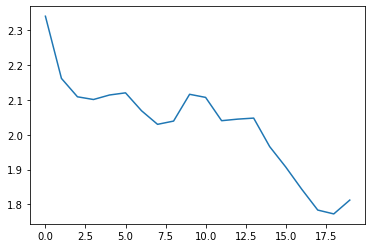

In [10]:
# Display loss
plt.figure()
plt.plot(loss_list)
plt.show()

(20, 1024, 2048)
(20, 1024, 2048)
(20, 1024, 2048)
(20, 1024, 2048)
(20, 1024, 2048)


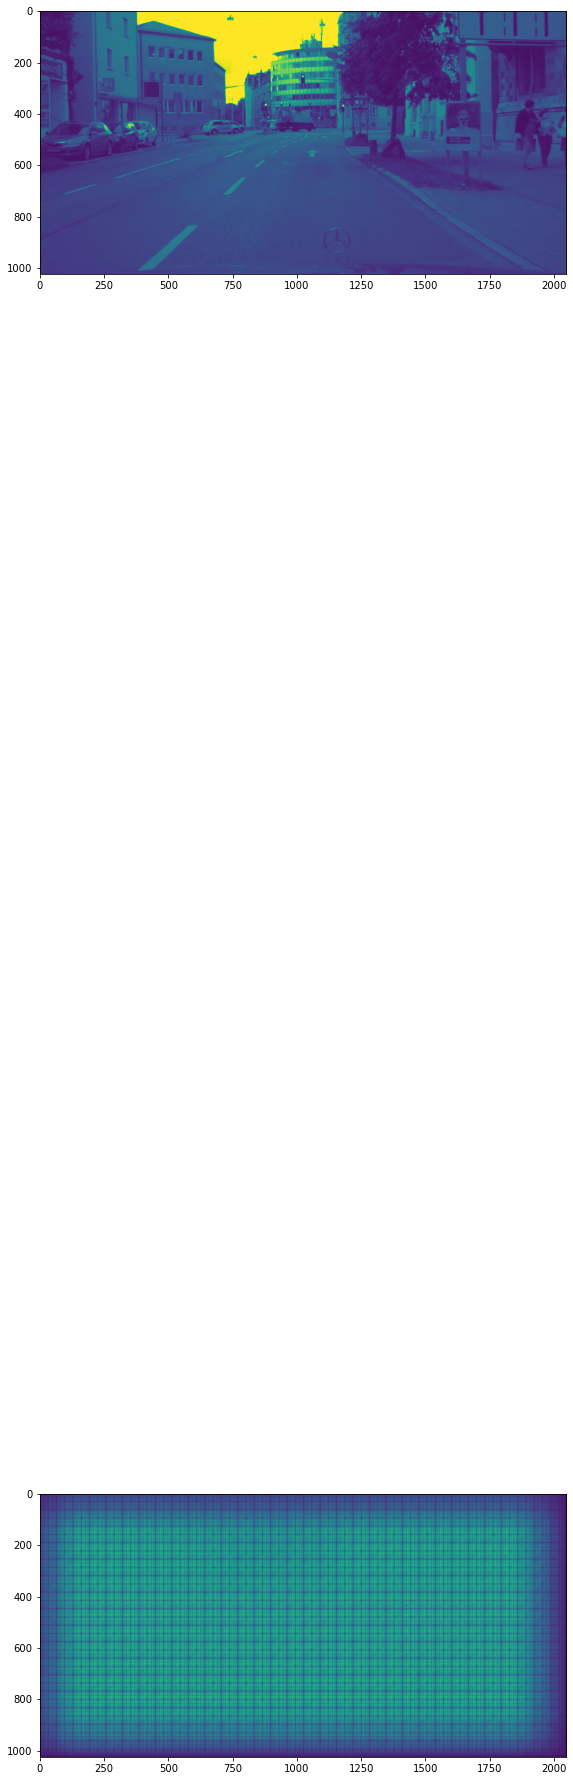

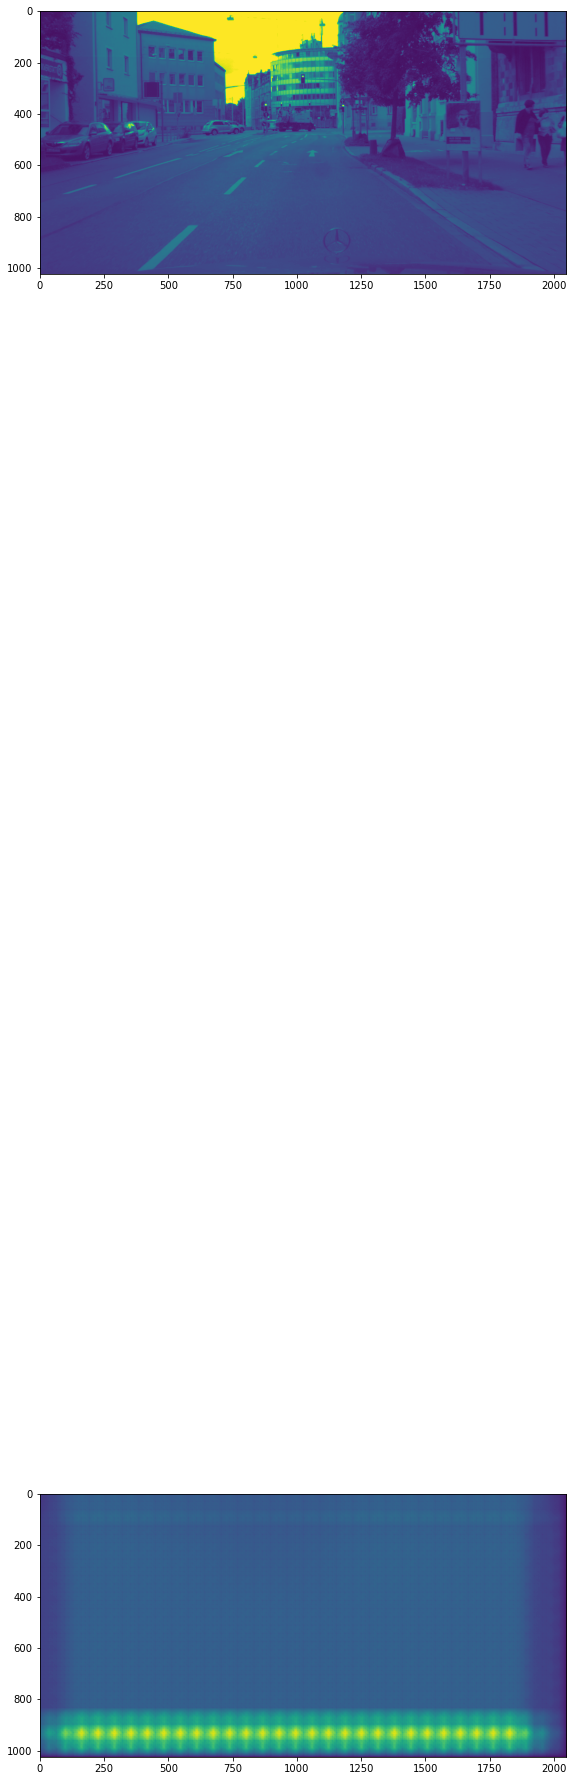

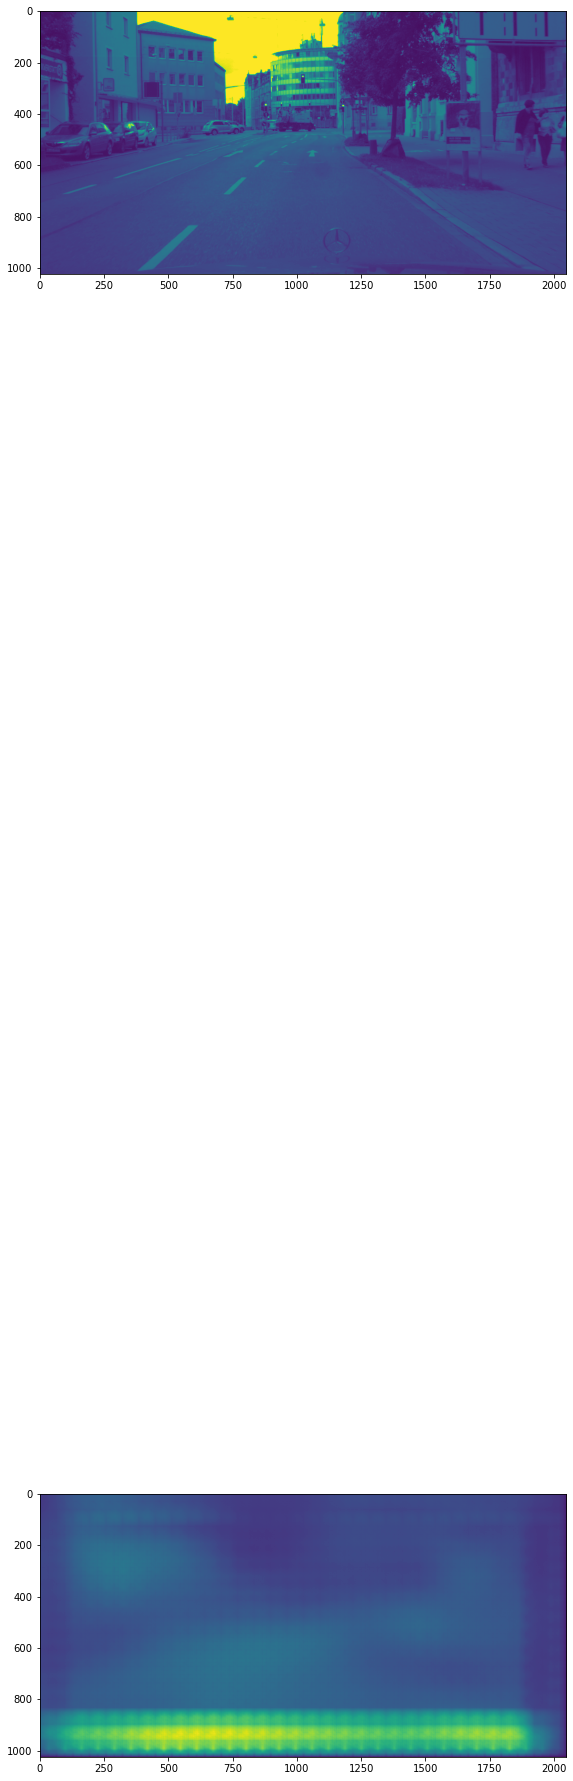

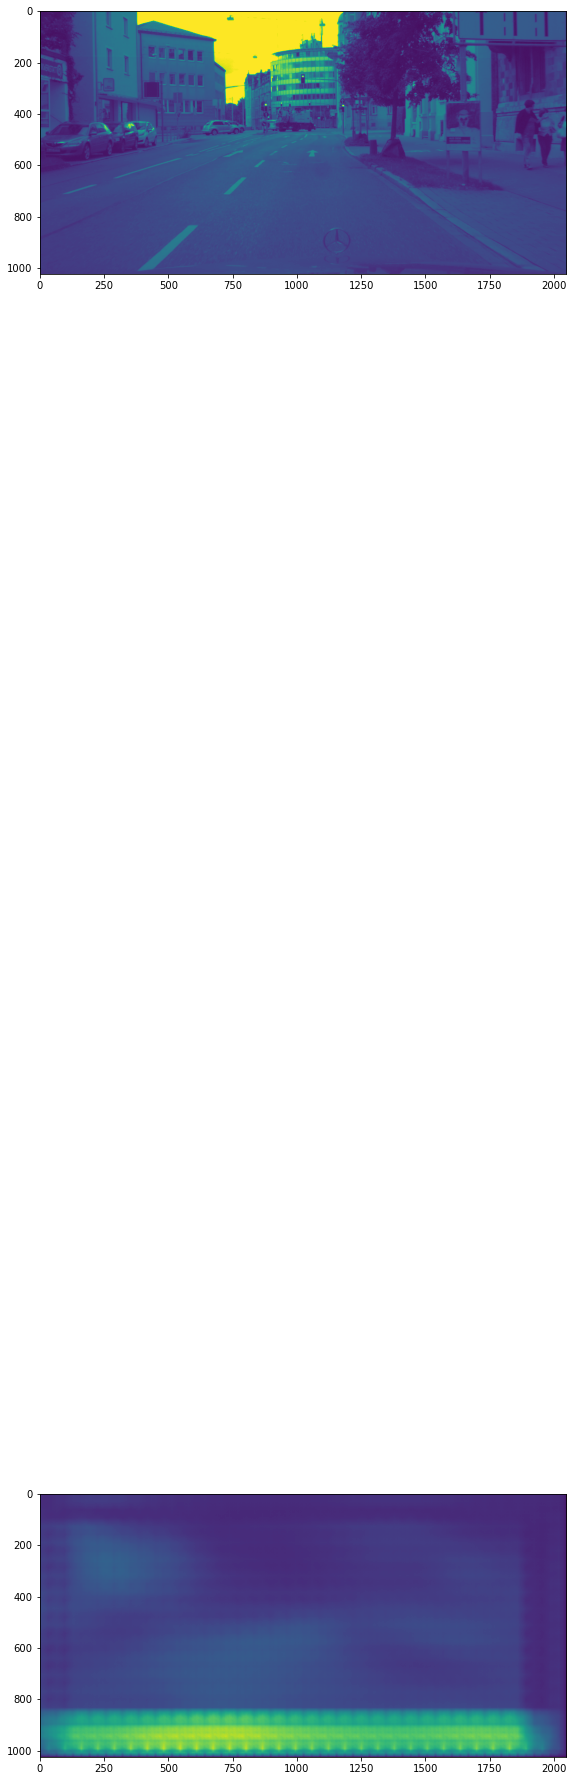

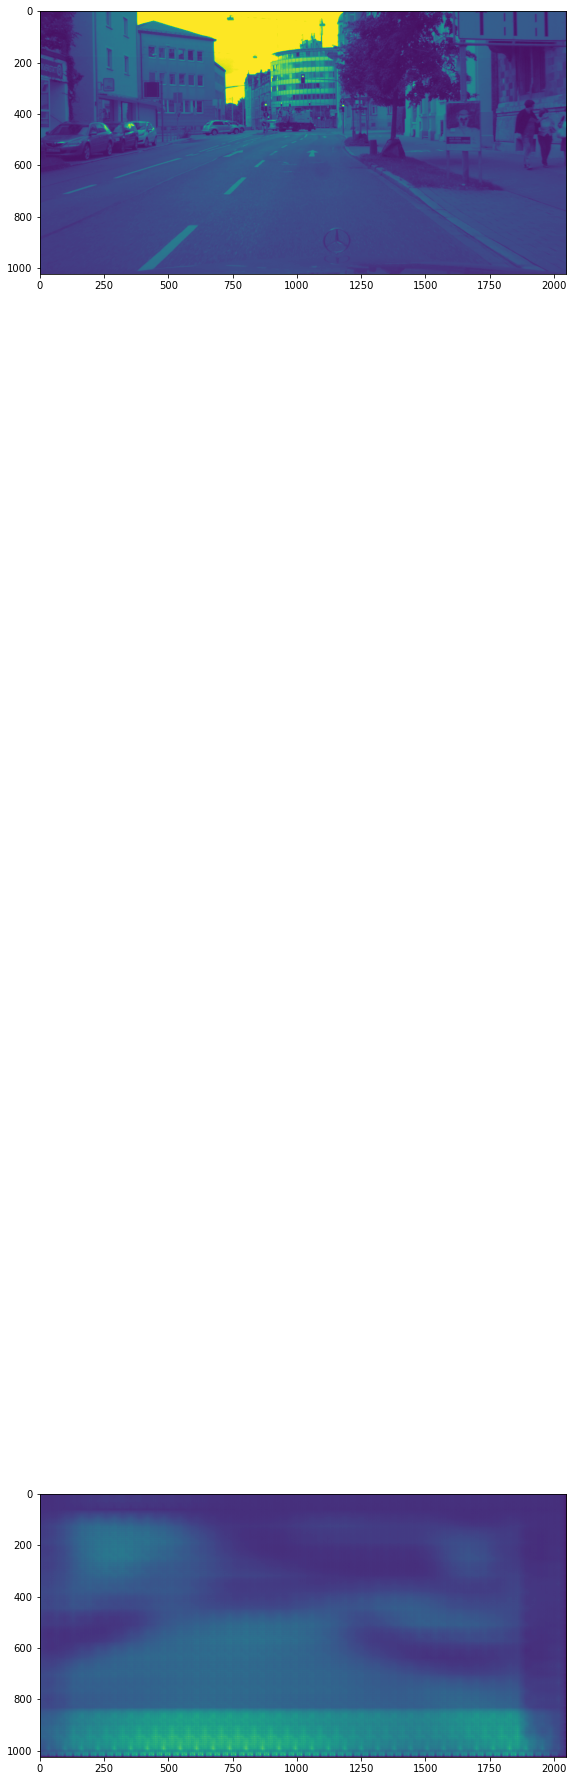

In [11]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize = (100, 50))
    imgs = outputs_list[k][1].cpu().detach().numpy()
    recon = outputs_list[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        print(item.shape)
        plt.imshow(item[0,:,:])